# Setup

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

/home/sigis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
#data = pd.read_csv('data/all_annotations.tsv', sep='\t')
data = pd.read_csv('data/updated_chords.csv')

#Get a list of the chords that appear more than once
chord_dist = data[['chord']].groupby('chord')[['chord']].count()
common = chord_dist[chord_dist[['chord']] > 1].dropna().index.values

#Remove rare chords
data = data[data.chord.isin(common)]

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#Only keep the chords???
tx = y

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.99, shuffle = False)

# Data exploration

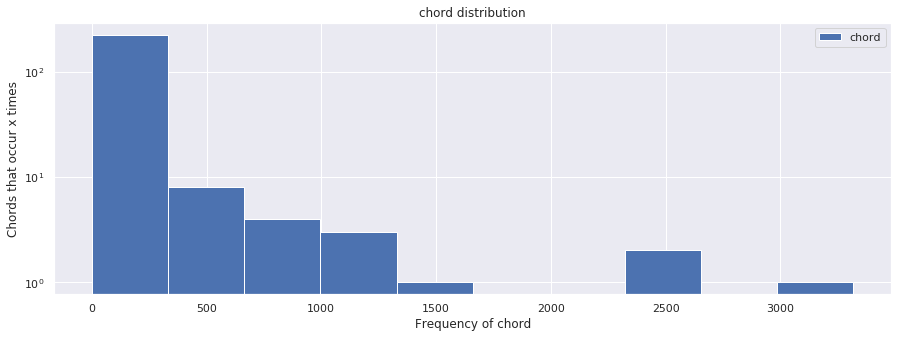

In [3]:
#Count how many times each chord appear
chord_dist = data[['chord']].groupby('chord')['chord'].count()

#Sort them and make them into a dataframe
chord_dist = chord_dist.sort_values(ascending = False)
chord_dist = pd.DataFrame(chord_dist)

#Plot the distribution
ax = chord_dist.plot.hist(figsize = [15,5])
ax.semilogy()
ax.set_xlabel("Frequency of chord")
ax.set_ylabel("Chords that occur x times")
_=ax.set_title("chord distribution")


# Helper Functions

In [4]:
def disp_results(history_object):
    """
    Takes a history object and plots the evolution of the metrics as well as the final scores
    """
    history = history_object
    df = pd.DataFrame({'epochs': history.epoch,
                       'accuracy': history.history['acc'],
                       'validation_accuracy': history.history['val_acc'],
                       'loss': history.history['loss'], 
                       'val_loss': history.history['val_loss']})


    #Plot the the scores on the validation and training sets
    df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
    df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

    a = history.history['acc'][-1]
    va= history.history['val_acc'][-1]
    l = history.history['loss'][-1]
    vl= history.history['val_loss'][-1]

    print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
    
    print(model.summary())
    plt.show()

In [5]:
def generate_sequences(train_x, train_y, seq_length):
    """
    Input:
        train_x, train_y: the data we want to transform into sequences
        seq_length: the length of the sequences
    Return:
        lstm_x: a matrix where elements are on the form (sequence, sequence length, features)
        lstm_y: a matrix where elements are on the form (sequence, classes)
    Notes: 
        Does not generate sequences for the last (seq_length - 1) datapoints
        Takes quite a lot of computing with long sequence lengths.
        
        
    """
    #containers for the sequences we generate
    lstm_input = []
    lstm_output = []
    
    for i in range(0, train_x.shape[0] - (seq_length +1)):
        #Create a sequence
        in_data = train_x.iloc[i:seq_length + i].values
        lstm_input.append(in_data)
        
        #Select the chord that would have appeared after the sequence
        out_data = train_y.iloc[seq_length + i].values
        lstm_output.append(out_data) 

    #Convert to arrays
    lstm_x = np.array(lstm_input)
    lstm_y = np.array(lstm_output)
    
    return lstm_x, lstm_y

# Models

In [6]:
def sequential(classes, features, optimizer, loss, metrics):
    """
    A sequential neural network. You train on features until you learn to predict a chord from its corresponding features.
    The kind of model we would have used if we wanted to predict to do chord classification.
    Just for testing purposes.
    """
    #Setup basic model
    model = tf.keras.Sequential()
    
    # Input layer. One node for each feature
    model.add(layers.Dense(256, input_dim = features, activation='relu'))
    
    # Hidden layer
    model.add(layers.Dense(256, activation='relu'))

    # Output layer. One node for each class
    model.add(layers.Dense(classes, activation='softmax'))

    #Compile the model with the chosen parameters
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics= metrics)
    return model

In [7]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    """
    A LSTM, a neural network operating on sequences to predict next items in a sequence.
    Needs some data preprocessing to generate sequences
    """
    # Input layers
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]))) 
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Activation('softmax')) 
    
    #Output layers
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    #Hyperparameters
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

# Train

## Setup

In [8]:
#Define parameters
classes = y.shape[1]
features = tx.shape[1]
optimizer = optimizers.RMSprop()
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#Save the weights whenever we get a new best validation score in a file so we can restart from that point
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

#callbacks_list = [checkpoint]     
callbacks_list = []  

#Load previous weights
#model.load_weights('weights.10-4.13.hdf5')

## Fit

In [9]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 5)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 0,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h1 = history

In [10]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 0,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h2 = history

In [11]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 20)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 1,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h3 = history

Train on 206 samples, validate on 52 samples
Epoch 1/1
206/206 [==============================] - 9s 44ms/step - loss: 5.4889 - acc: 0.0049 - val_loss: 5.4679 - val_acc: 0.0000e+00


In [12]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 40)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 1,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h4 = history

Train on 190 samples, validate on 48 samples
Epoch 1/1
190/190 [==============================] - 13s 68ms/step - loss: 5.4908 - acc: 0.0053 - val_loss: 5.4668 - val_acc: 0.0000e+00


In [13]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 80)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 1,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h5 = history

Train on 158 samples, validate on 40 samples
Epoch 1/1
158/158 [==============================] - 24s 155ms/step - loss: 5.4911 - acc: 0.0127 - val_loss: 5.4702 - val_acc: 0.0250


In [ ]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 160)

#Generate model
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 30,
                    verbose = 1,
                    batch_size = 64,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h6 = history

Train on 94 samples, validate on 24 samples
Epoch 1/1


# Results

Final values
acc
0.013761468060793133
valacc
0.0181818176060915
loss
5.489627103193091
valoss
5.473270416259766

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 150, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

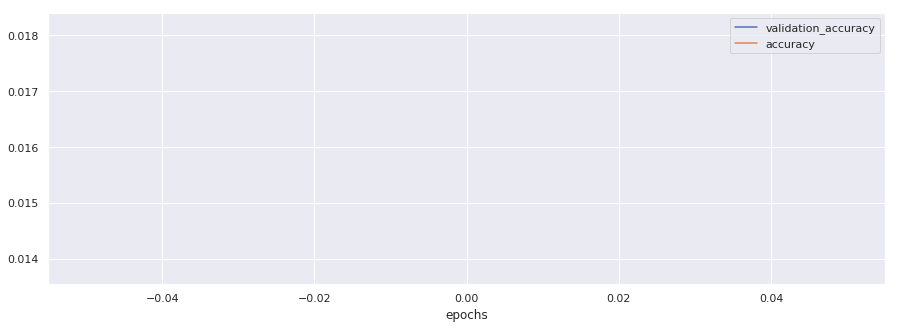

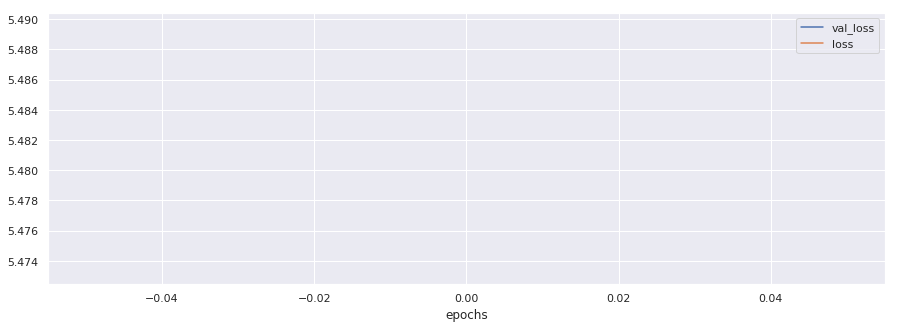

Final values
acc
0.009345794531786553
valacc
0.018518518656492233
loss
5.48928748781436
valoss
5.467419624328613

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 150, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

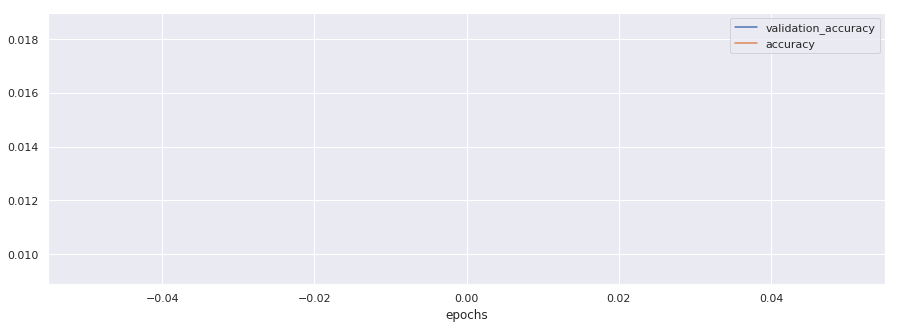

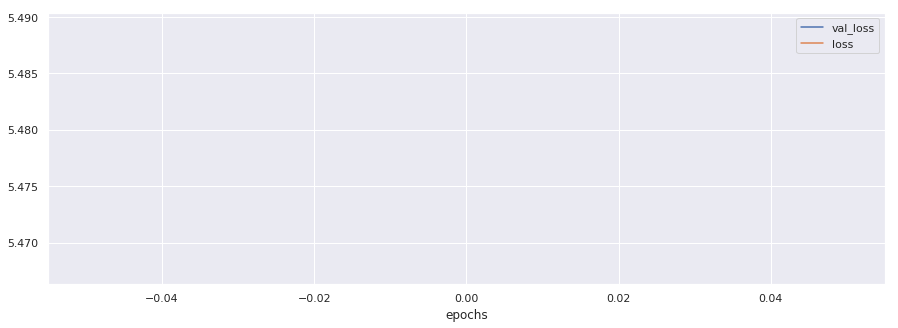

Final values
acc
0.0048543689320388345
valacc
0.0
loss
5.488914577706346
valoss
5.467881202697754

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 150, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
___________________________________________

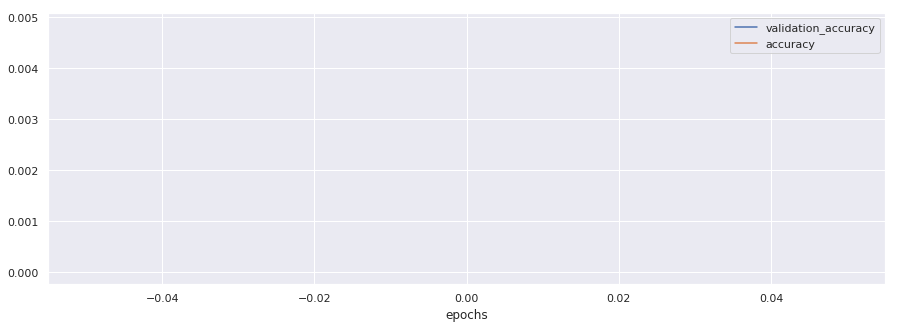

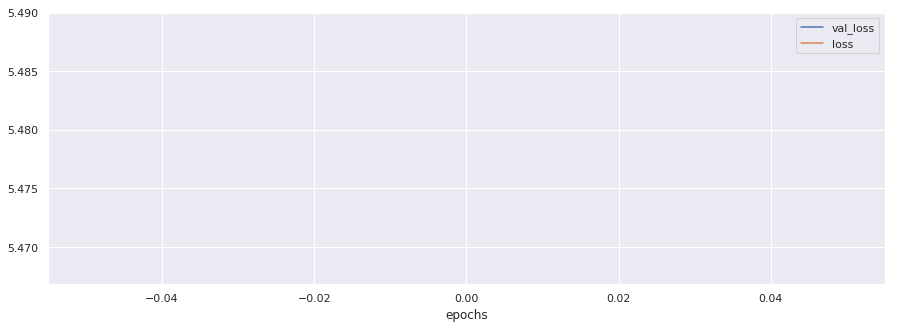

Final values
acc
0.005263157894736842
valacc
0.0
loss
5.4908088884855575
valoss
5.4668426513671875

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 150, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
__________________________________________

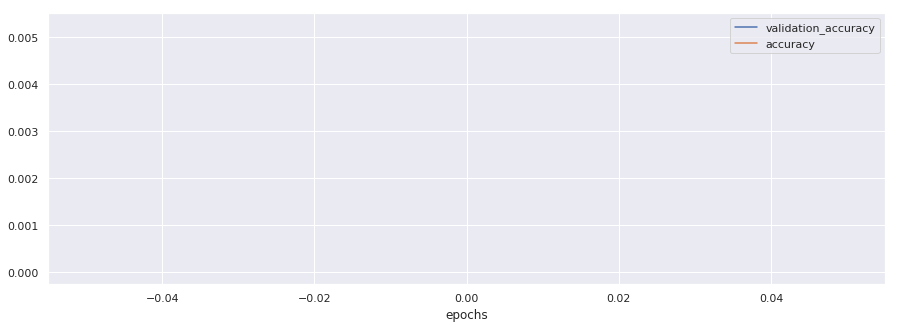

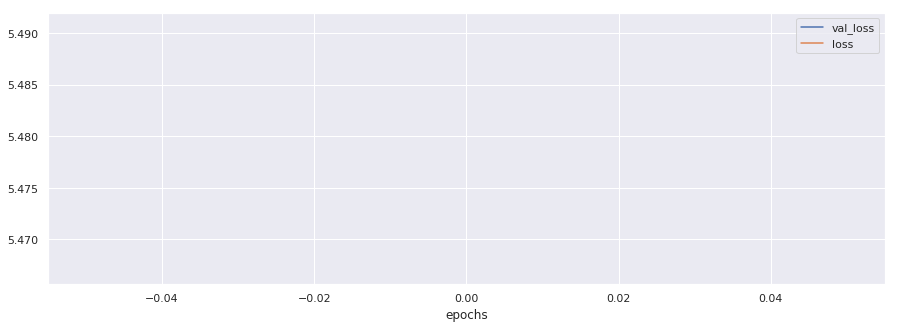

Final values
acc
0.012658228178190279
valacc
0.02500000037252903
loss
5.491079529629478
valoss
5.470241069793701

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 150, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

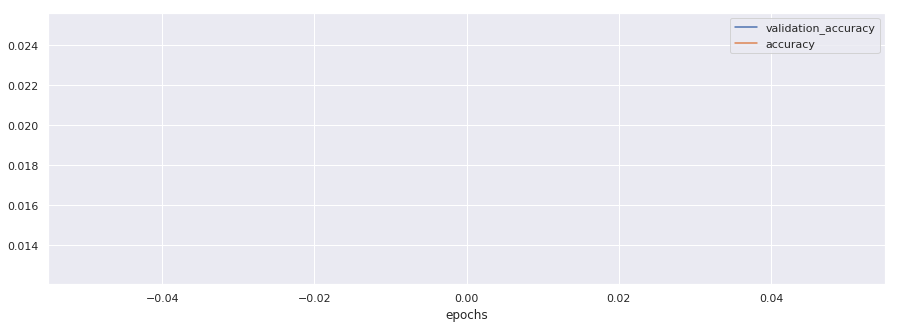

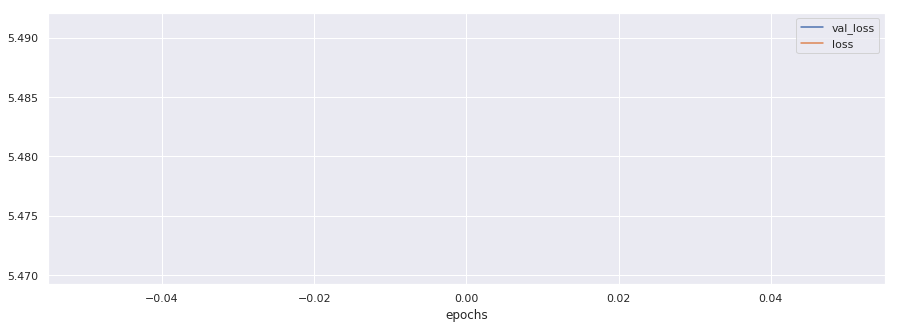

Final values
acc
0.0
valacc
0.11538461595773697
loss
5.494852664423924
valoss
5.481722831726074

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 150, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________________________

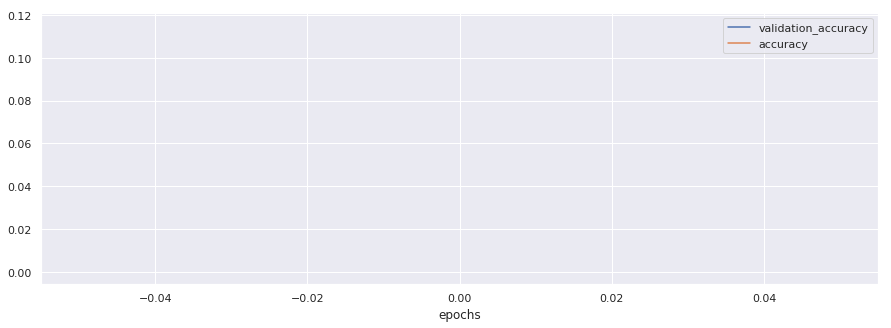

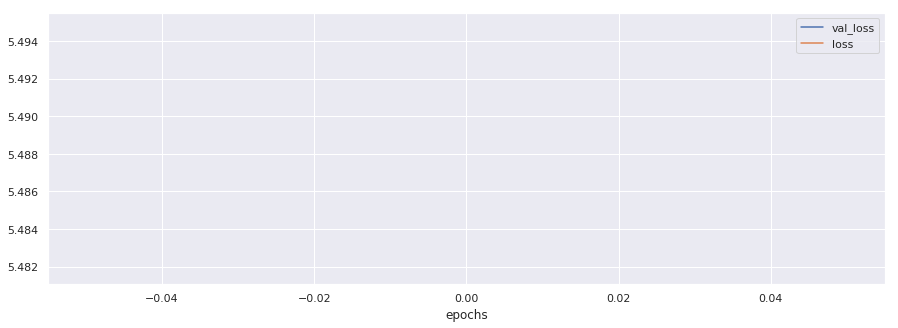

In [15]:
disp_results(h1)
disp_results(h2)
disp_results(h3)
disp_results(h4)
disp_results(h5)
disp_results(h6)